In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# IMPORT AND READ DATASET


In [ ]:
from multiprocessing.connection import wait
import sys
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
data = np.load('megmag_data.npy')


# Describe data structure


In [ ]:
dshape  = data.shape
print('Megmag data shape: {}'.format(dshape))


# Add time offset (ms)


In [ ]:
times = np.arange(-200, 801, 4)
print('Time offset array shape: {}'.format(times.shape))


# Create covariance matrix


In [ ]:
output = []
for i in range(len(data)):
  X = data[i]
  Xt = X.T
  output.append(np.matrix(np.dot(X,Xt)))
cov_mat = 1  / dshape[0] * np.sum(i for i in output)
print('Covariance matrix shape: {}'.format(cov_mat.shape))
plt.imshow(cov_mat)
plt.show()


# Create signal averages across repititions


In [ ]:
avg_for_reps = np.mean(data, axis=0).T
print('Average for each repetition shape: {}'.format(avg_for_reps.shape))
plt.plot(avg_for_reps)
plt.axvline()
plt.axhline()
plt.show()


# Find and plot maximum response channel


In [ ]:
max_resp = np.unravel_index(np.argmax(avg_for_reps), avg_for_reps.shape)
print('Max response index: {}, data shape: {}'.format(max_resp, data.shape))
#plot average for all repititions
plt.plot(times, avg_for_reps[:, max_resp[1]])
plt.axvline()
plt.axvline(x = times[max_resp[0]], color='r', label='max response')
plt.axhline()
plt.show()

# plot all repititions for max response channel
plt.plot(times, data[:, max_resp[1], :].squeeze().T)
plt.axvline()
plt.axvline(x = times[max_resp[0]], color='r', label='max response')
plt.axhline()

plt.show()


# load pas_vector.npy (call it y)


In [ ]:
y = np.load('pas_vector.npy')
# same as number of repititions
print('Pas vector shape: {}'.format(y.shape))
pas_data = []
pas_index = {}
for i in np.unique(y):
  print('Creating pas slice for pas {}'.format(i))
  pas_slice = np.argwhere(y == i)
  data_slice = data[pas_slice].squeeze()
  pas_data.append({
    'paslevel': i,
    'data': data_slice,
  })
  pas_index[i] = len(pas_data) - 1
for i in pas_data:
  print('Pas {} shape: {}'.format(i['paslevel'], i['data'].shape))
  avg_for_pas = np.mean(i['data'][:,max_resp[1],:], axis=0).T
  print('Pas {} average shape: {}'.format(i['paslevel'], avg_for_pas.shape))
  plt.plot(times, avg_for_pas, label='Pas {}'.format(i['paslevel']))
plt.axvline()
plt.axhline()
plt.axvline(x = times[max_resp[0]], color='r', label='max response')
plt.legend(loc="upper left")
plt.title('Average response for each pas level')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()


# Exercise 2


Data for pas 1 and 2 shape: (214, 102, 251)
y for pas 1 and 2 shape: (214,)
Reshaped data for pas 1 and 2 shape: (214, 25602)
Logistic regression score with no penalty: 1.0
Classes found in regression: [1 2]
Total coefs: 25602
Nonzero coefs: 25602
Zero coefs: 0
Logistic regression score with l1 penalty: 1.0
Classes found in regression: [1 2]
Total coefs: (1, 25602)
Total coefs: 25602
Nonzero coefs: 222
Zero coefs: 25380
Covariance matrix shape: (1, 1)


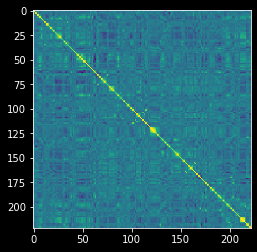

In [15]:
# create a new array called data_1_2 that only contains PAS responses 1 and 2
data_1_2 = np.concatenate((pas_data[pas_index[1]]['data'], pas_data[pas_index[2]]['data']), axis = 0)
print('Data for pas 1 and 2 shape: {}'.format(data_1_2.shape))
# Similarly, create a y_1_2 for the target vector
y_1_2 = y[np.where((y == 1) | (y == 2))]
print('y for pas 1 and 2 shape: {}'.format(y_1_2.shape))
#Our data_1_2 is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use np.reshape to create a variable X_1_2 that fulfils these criteria.
X_1_2 = np.reshape(data_1_2, (data_1_2.shape[0], data_1_2.shape[1] * data_1_2.shape[2]))
print('Reshaped data for pas 1 and 2 shape: {}'.format(X_1_2.shape))
#  and scale X_1_2
sc = StandardScaler()
sc.fit(X_1_2)
X_1_2_std = sc.transform(X_1_2)
# Do a standard LogisticRegression - make sure there is no penalty applied
lr = LogisticRegression(penalty='none', solver='lbfgs', multi_class='ovr', n_jobs=-1)
lr.fit(X_1_2_std, y_1_2)
# we get a score of 1.0...that'd definitely an overfit, right? haha
print('Logistic regression score with no penalty: {}'.format(lr.score(X_1_2_std, y_1_2)))
#found classes
print('Classes found in regression: {}'.format(lr.classes_))
# total coefs
coefs_orig = lr.coef_
coefs = len(lr.coef_[0])
print('Total coefs: {}'.format(coefs))
# non-zero coefs
coefs_nonzero = len(lr.coef_[0].nonzero()[0])
print('Nonzero coefs: {}'.format(coefs_nonzero))
# zero coefs
coefs_zero = coefs - coefs_nonzero
print('Zero coefs: {}'.format(coefs_zero))
# apply l1 penalty
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr')
lr.fit(X_1_2_std, y_1_2)
print('Logistic regression score with l1 penalty: {}'.format(lr.score(X_1_2_std, y_1_2)))
# default_threshold = np.get_printoptions()['threshold']
# np.set_printoptions(threshold=sys.maxsize)
# print(lr.coef_)
# np.set_printoptions(threshold=default_threshold)
#found classes
print('Classes found in regression: {}'.format(lr.classes_))
# total coefs
print('Total coefs: {}'.format(lr.coef_.shape))
coefs_orig = lr.coef_[0]
coefs = len(lr.coef_[0])
print('Total coefs: {}'.format(coefs))
# non-zero coefs
coefs_nonzero = len(lr.coef_[0].nonzero()[0])
print('Nonzero coefs: {}'.format(coefs_nonzero))
# zero coefs
coefs_zero = coefs - coefs_nonzero
print('Zero coefs: {}'.format(coefs_zero))
# part 2.1.3: something is wrong with the above code because there is only one non-zero coefficient.

cov_nz_index = lr.coef_[0].nonzero()[0]
X_reduced = X_1_2_std[:,cov_nz_index]

cmat = X_reduced.T @ X_reduced

plt.imshow(cmat, cmap='viridis')
plt.show()



# Exercise 2.2


In [ ]:
def equalize_targets_class(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) < 2:
        raise NameError("at least 2 targets required")
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    choices = []
    for i in range(len(targets)):
        choices.append(np.random.choice(indices[i], size=min_count, replace=False))
    
    # create the new data sets
    new_indices = np.concatenate(tuple(choices))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y


# Stratified 5-fold cross validation logistic model


In [ ]:
X_1_2_equal, y_1_2_equal = equalize_targets_class(data_1_2, y_1_2)
X_1_2_equal = np.reshape(X_1_2_equal, (X_1_2_equal.shape[0], X_1_2_equal.shape[1] * X_1_2_equal.shape[2]))
sc.fit(X_1_2_equal)
X_1_2_equal_std = sc.transform(X_1_2_equal)
cv = StratifiedKFold(n_splits=5)
lr = LogisticRegression(penalty='none', solver='lbfgs', multi_class='ovr', n_jobs=-1) # no regularisation
print('Getting cross validation score (Stratified 5-fold)...')
scores = cross_val_score(lr, X_1_2_equal_std, y_1_2_equal, cv=cv)
print('Cross validation score (Stratified 5-fold): '.format(np.mean(scores)))


# Stratified 5-fold cross validation logistic model with l2


In [ ]:
best_score = 0.0
for c in [1e5, 1e1, 1e-5]:
  print('Getting cross validation score (Stratified 5-fold, C={})...'.format(c))
  lr = LogisticRegression(penalty='l2', solver='lbfgs', multi_class='ovr', C=c, n_jobs=-1)
  scores = cross_val_score(lr, X_1_2_equal_std, y_1_2_equal, cv=cv)
  score = np.mean(scores)
  print('Cross validation score (Stratified 5-fold, C={}): {}'.format(c, score))
  if score >= best_score:
    best_score = score
    best_c = c
print('Best C: {}'.format(best_c))


# now fit a model for each time sample using best c


In [ ]:
# 2.2.v
scores = []
lr = LogisticRegression(penalty='l2', solver='newton-cg', multi_class='ovr', C=best_c, n_jobs=-1)
X_1_2_equal, y_1_2_equal = equalize_targets_class(data_1_2, y_1_2)
print('Fitting l2 model (c={}) for time sample: '.format(best_c), end='', flush=True)
for time_ofs in range(data_1_2.shape[2]):
  X_1_2_equal_time = X_1_2_equal[:, :, time_ofs].squeeze()
  print('{}'.format(time_ofs), end='..', flush=True)
  # print('Shape of X: {}'.format(X_1_2_equal_time.shape))
  sc.fit(X_1_2_equal_time)
  X_1_2_equal_std = sc.transform(X_1_2_equal_time)
  # print('Getting Cross validation score (Stratified 5-fold, C={}, time={}ms)'.format(best_c, times[time_ofs]))
  time_scores = cross_val_score(lr, X_1_2_equal_std, y_1_2_equal, cv=cv)
  score = np.mean(time_scores)
  # print('Cross validation score (Stratified 5-fold, C={}, time={}ms): {}'.format(best_c, times[time_ofs], score))
  scores.append(score)
print('\nCompleted fitting time-based models')
scores = np.array(scores)
max_score = np.unravel_index(np.argmax(scores), scores.shape)
print('Best score: {} at timestamp {}ms'.format(scores[max_score], times[max_score[0]]))
plt.plot(times, scores)
plt.axvline(x = times[max_score[0]], color='r', label='max model score')
plt.axhline(y = 0.5, label = 'random chance', color='w')
plt.legend(loc="upper left")
plt.show()


# now fit a model for each time sample using c=1e-1 and l1


In [ ]:
scores = []
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=1e-1)
X_1_2_equal, y_1_2_equal = equalize_targets_class(data_1_2, y_1_2)
print('Fitting l1 model (c=1e-1) for time sample: ', end='', flush=True)
for time_ofs in range(data_1_2.shape[2]):
  X_1_2_equal_time = X_1_2_equal[:, :, time_ofs].squeeze()
  print('{}'.format(time_ofs), end='..', flush=True)
  # print('Shape of X: {}'.format(X_1_2_equal_time.shape))
  sc.fit(X_1_2_equal_time)
  X_1_2_equal_std = sc.transform(X_1_2_equal_time)
  # print('Getting Cross validation score (Stratified 5-fold, C={}, time={}ms)'.format(best_c, times[time_ofs]))
  time_scores = cross_val_score(lr, X_1_2_equal_std, y_1_2_equal, cv=cv)
  score = np.mean(time_scores)
  # print('Cross validation score (Stratified 5-fold, C={}, time={}ms): {}'.format(best_c, times[time_ofs], score))
  scores.append(score)
print('\nCompleted fitting time-based models')
scores = np.array(scores)
max_score = np.unravel_index(np.argmax(scores), scores.shape)
print('Best score: {} at timestamp {}ms'.format(scores[max_score], times[max_score[0]]))
plt.plot(times, scores)
plt.axvline(x = times[max_score[0]], color='r', label='max model score')
plt.axhline(y = 0.5, label = 'random chance', color='w')
plt.legend(loc="upper left")
plt.show()


# fit again but for PAS 1 and 4


In [ ]:
data_1_4 = np.concatenate((pas_data[pas_index[1]]['data'], pas_data[pas_index[4]]['data']), axis = 0)
print('Data for pas 1 and  4 shape: {}'.format(data_1_4.shape))
y_1_4 = y[np.where((y == 1) | (y == 2))]
print('y for pas 1 and 4 shape: {}'.format(y_1_4.shape))
#Our data_1_2 is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use np.reshape to create a variable X_1_2 that fulfils these criteria.
X_1_4 = np.reshape(data_1_4, (data_1_4.shape[0], data_1_4.shape[1] * data_1_4.shape[2]))
scores = []
lr = LogisticRegression(penalty='l1', solver='liblinear', multi_class='ovr', C=1e-1)
X_1_4_equal, y_1_4_equal = equalize_targets_class(data_1_4, y_1_4)
print('Fitting l1 model (c=1e-1) for time sample: ', end='', flush=True)
for time_ofs in range(data_1_4.shape[2]):
  X_1_4_equal_time = X_1_4_equal[:, :, time_ofs].squeeze()
  print('{}'.format(time_ofs), end='..', flush=True)
  # print('Shape of X: {}'.format(X_1_4_equal_time.shape))
  sc.fit(X_1_4_equal_time)
  X_1_4_equal_std = sc.transform(X_1_4_equal_time)
  # print('Getting Cross validation score (Stratified 5-fold, C={}, time={}ms)'.format(best_c, times[time_ofs]))
  time_scores = cross_val_score(lr, X_1_4_equal_std, y_1_4_equal, cv=cv)
  score = np.mean(time_scores)
  # print('Cross validation score (Stratified 5-fold, C={}, time={}ms): {}'.format(best_c, times[time_ofs], score))
  scores.append(score)
print('\nCompleted fitting time-based models')
scores = np.array(scores)
max_score = np.unravel_index(np.argmax(scores), scores.shape)
print('Best score: {} at timestamp {}ms'.format(scores[max_score], times[max_score[0]]))
plt.plot(times, scores)
plt.axvline(x = times[max_score[0]], color='r', label='max model score')
plt.axhline(y = 0.5, label = 'random chance', color='w')
plt.legend(loc="upper left")
plt.show()


# EXERCISE 3 - Do a Support Vector Machine Classification on all four PAS-ratings


In [ ]:
# 3.1.i
X_equal, y_equal = equalize_targets_class(data, y)
print('X shape: {}'.format(X_equal.shape))
print('y shape: {}'.format(y_equal.shape))

X_equal_f = np.reshape(X_equal, (X_equal.shape[0], X_equal.shape[1] * X_equal.shape[2]))

sc.fit(X_equal_f)
X_equal_std = sc.transform(X_equal_f)

print('X reshaped shape: {}'.format(X_equal_std.shape))


## Linear kernel classifier

In [ ]:
cv = StratifiedKFold()
svm = SVC(kernel='linear')
scores_svm = cross_val_score(svm, X_equal_std, y_equal, cv=cv)
print(np.mean(scores_svm))

## Radial basis

In [ ]:
cv = StratifiedKFold()
svm = SVC(kernel='rbf')
scores_svm = cross_val_score(svm, X_equal_std, y_equal, cv=cv)
print(np.mean(scores_svm))

## Sample-by-sample analysis

In [ ]:
# radial basis score better than linear
cv = StratifiedKFold()
svm = SVC(kernel='rbf')

scores = []
print(X_equal.shape)
print('Fitting rbv svm model time sample: ', end='', flush=True)
for time_ofs in range(X_equal.shape[2]):
  X_equal_time = X_equal[:, :, time_ofs].squeeze()
  print('{}'.format(time_ofs), end='..', flush=True)
  # print('Shape of X: {}'.format(X_1_2_equal_time.shape))
  sc.fit(X_equal_time)
  X_equal_std = sc.transform(X_equal_time)
  # print('Getting Cross validation score (Stratified 5-fold, C={}, time={}ms)'.format(best_c, times[time_ofs]))
  time_scores = cross_val_score(svm, X_equal_std, y_equal, cv=cv)
  score = np.mean(time_scores)
  # print('Cross validation score (Stratified 5-fold, C={}, time={}ms): {}'.format(best_c, times[time_ofs], score))
  scores.append(score)
print('\nCompleted fitting time-based models')
scores = np.array(scores)
max_score = np.unravel_index(np.argmax(scores), scores.shape)
print('Best score: {} at timestamp {}ms'.format(scores[max_score], times[max_score[0]]))
plt.plot(times, scores)
# random chance is 1/4
plt.axvline(x = times[max_score[0]], color='r', label='max model score')
plt.axhline(y = 0.25, label = 'random chance', color='w')
plt.legend(loc="upper left")
plt.show()

## Exercies 3.2 Test/train

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_equal, y_equal, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
# assignment says: This time your features are the number of sensors multiplied by the number of samples.
# So, we need to reshape the data to be (n_samples, n_features)
X_train_f = np.reshape(X_train, (X_train.shape[0], X_train.shape[1] * X_train.shape[2]))
X_test_f = np.reshape(X_test, (X_test.shape[0], X_test.shape[1] * X_test.shape[2]))

sc.fit(X_train_f)
X_train_f_std = sc.transform(X_train_f)
X_test_f_std = sc.transform(X_test_f)

svm = SVC(kernel='rbf')

svm.fit(X_train_f_std, y_train)
predictions = svm.predict(X_test_f_std)
print('Accuracy: {}'.format(accuracy_score(y_test, predictions)))
# confusion matrix
# print(confusion_matrix(y_test, predictions))
ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['PAS 1', 'PAS 2', 'PAS 3', 'PAS 4'])
plt.show()